## Cluster analysis(군집화 분석)

* Cluster analysis(군집화 분석)이란 주어진 데이터들의 특성을 고려해 데이터 집단(Cluster)을 정의하고 데이터 집단의 대표할 수 있는 대표점을 찾는 것으로 데이터 마이닝의 한 방법이다. 

* Cluster란 비슷한 특성을 가진 데이터들의 집단. 반대로 데이터의 특성이 다르면 다른 클러스터에 속해야 한다.

* 효율성 : Cluster 분석을 통해 수백만의 데이터를 직접 확인하지 않고 각각 Cluster의 대표값만 확인해 전체 데이터의 특성을 파악할 수 있다.

출처 : [클러스터 분석 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0_%EB%B6%84%EC%84%9D)


## scikit-learn의 Clustering 알고리즘 비교
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png">

출처 : [scikit-learn 2.3.1. Overview of clustering method](https://scikit-learn.org/stable/modules/clustering.html#clustering)


## K-Means

* 주어진 데이터를 k개의 클러스터로 묶는 알고리즘으로, 각 클러스터와 거리 차이의 분산을 최소화하는 방식으로 동작한다. 

* 이 알고리즘은 자율 학습의 일종으로, 레이블이 달려 있지 않은 입력 데이터에 레이블을 달아주는 역할을 수행한다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Kmeans_animation_withoutWatermark.gif/220px-Kmeans_animation_withoutWatermark.gif">

출처 : [K-평균_알고리즘 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/K-%ED%8F%89%EA%B7%A0_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98)

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 파일 불러오기

In [3]:
# rfm.csv 파일을 읽어오고, index는 "CustomerID"로 설정해 줍니다.

rfm = pd.read_csv("../CSV/rfm.csv")
rfm = rfm.set_index("CustomerID")
rfm.head(3)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver
12347.0,2,182,4310.00,5,5,5,555,15,platinum
12348.0,75,31,1797.24,2,3,4,234,9,gold


## rfm_cluster 변수 생성

In [6]:
# iloc를 사용하여 Recency, Frequency, MonetaryValue 컬럼 데이터를 rfm_cluster 변수에 담습니다.

rfm_cluster = rfm.iloc[:, :3]
rfm_cluster.head(3)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24


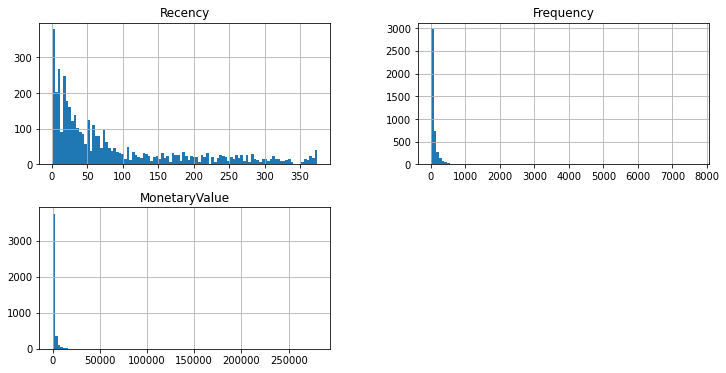

In [7]:
_ = rfm_cluster.hist(figsize = (12, 6), bins = 100)

## 정규화

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Binary_logarithm_plot_with_ticks.svg/1200px-Binary_logarithm_plot_with_ticks.svg.png" width="300">

In [9]:
# np.log1p 메서드를 사용하여 값들을 정규화 시켜주고, rfm_cluster_log 변수에 담습니다.
# 정규화시 np.log보다 np.log1p을 사용하는 이유는 x값이 1보다 작을 때, y값이 음의 무한대로 가는 것을 방지하기 위함입니다.
# 정규화를 함으로써 각 속성별로 다양한 수의 범위를 줄여줄 수 있습니다.

rfm_cluster_log = np.log1p(rfm_cluster) # == np.log(rfm_cluster + 1)
rfm_cluster_log.head(3)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,5.789960,0.693147,11.253955
12347.0,1.098612,5.209486,8.368925
12348.0,4.330733,3.465736,7.494564


array([[<AxesSubplot:title={'center':'Recency'}>,
        <AxesSubplot:title={'center':'Frequency'}>],
       [<AxesSubplot:title={'center':'MonetaryValue'}>, <AxesSubplot:>]],
      dtype=object)

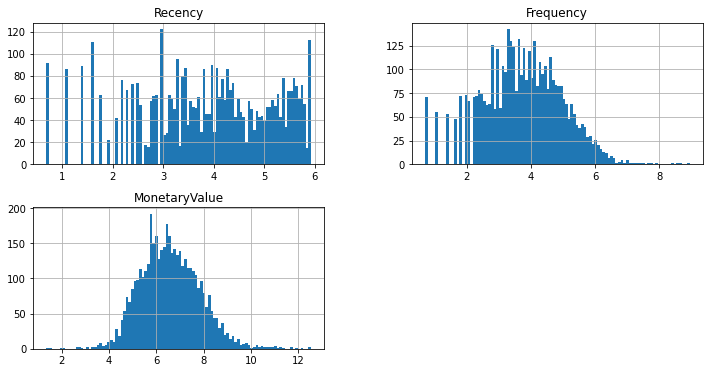

In [10]:
rfm_cluster_log.hist(figsize = (12, 6), bins = 100)

## 스케일 조정하기

In [11]:
# StandardScaler 메서드를 사용하여 속성 값의 범위가 크게 차이 나지 않도록 평균 0, 분산 1로 조정해 줍니다.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_cluster_log)

StandardScaler()

In [12]:
# fit_transform 메서드를 사용하여 rfm_cluster_log를 rfm_norm 변수에 담습니다.

rfm_norm = scaler.fit_transform(rfm_cluster_log)
rfm_norm

array([[ 1.46190736, -2.43788926,  3.71030846],
       [-2.0405272 ,  1.18891259,  1.41710205],
       [ 0.37248773, -0.211389  ,  0.72210361],
       ...,
       [-1.22033272, -0.93475683, -1.11156693],
       [-1.65915848,  2.2911166 ,  0.82490915],
       [-0.03554715,  0.42858907,  0.73960806]])

### K-Means 모델 학습

In [16]:
inertia = []
# rfm_norm 값을 학습하고
# 리스트에 inertia_ 값을 넣어 elbow 값을 봅니다.
from sklearn.cluster import KMeans

for i in range(1, 20) :
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(rfm_norm)
    inertia.append(kmeans.inertia_)

## 시각화

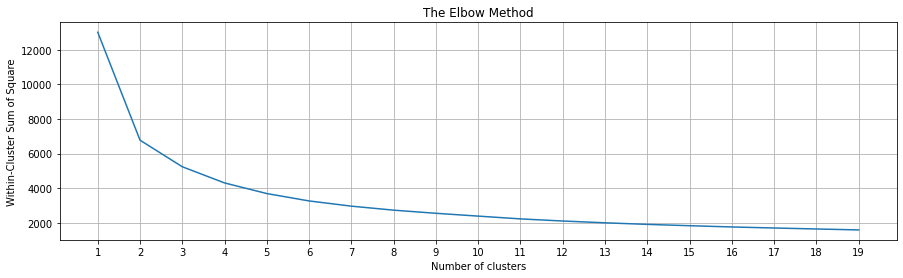

In [17]:
# The Elbow Method 그래프에서 급격히 떨어지는 구간을 확인하여, 적절한 K값을 확인해 봅니다.

plt.figure(figsize=(15,4))
plt.plot(range(1, 20), inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

In [18]:
# n_clusters의 수를 늘려 봅니다.

kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit(rfm_norm)

KMeans(n_clusters=5, random_state=42)

In [19]:
# cluster_centers_를 통해서 좌표값을 출력해 봅니다.
kmeans.cluster_centers_

array([[-1.35975328,  1.33399036,  1.38858251],
       [ 0.82352018, -0.27961079, -0.31657062],
       [-0.00889614,  0.66557371,  0.62457257],
       [-0.82827734, -0.27764174, -0.35994432],
       [ 0.83560811, -1.36471241, -1.22131938]])

In [20]:
# labels_를 통해서 어떤 클러스터에 속하는지 확인합니다.
kmeans.labels_

array([1, 0, 2, ..., 3, 0, 2], dtype=int32)

In [21]:
# rfm['Cluster']에 kmeans.labels_ 값을 담아줍니다.

rfm['Cluster'] = kmeans.labels_

<AxesSubplot:xlabel='Cluster', ylabel='RFM_score'>

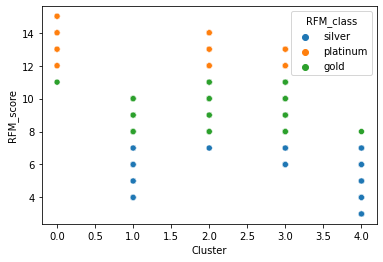

In [26]:
# Cluster와 RFM_score의 상관관계를 살펴보기 위해 scatterplot으로 산점도를 출력해 봅니다.(RFM_class를 통해 데이터를 구분할 수 있습니다.)
sns.scatterplot(data = rfm, x = "Cluster", y = "RFM_score", hue = "RFM_class")

<AxesSubplot:xlabel='Cluster', ylabel='RFM_score'>

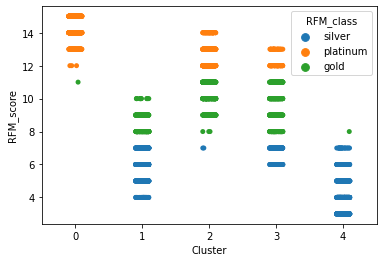

In [28]:
# stripplot은 scatterplot과 유사하나 데이터가 겹치면 양 옆으로 흩어진 형태를 보입니다.
sns.stripplot(data = rfm, x = "Cluster", y = "RFM_score", hue = "RFM_class")

<AxesSubplot:xlabel='MonetaryValue', ylabel='RFM_score'>

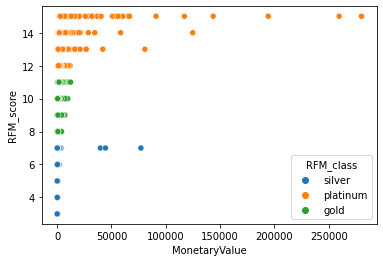

In [30]:
# MonetaryValue와 RFM_score의 상관관계를 살펴보기 위해 scatterplot으로 산점도를 출력해 봅니다.
# RFM_class를 통해 데이터를 구분할 수 있습니다.
sns.scatterplot(data = rfm, x = "MonetaryValue", y = "RFM_score", hue = "RFM_class")

<AxesSubplot:xlabel='Frequency', ylabel='RFM_score'>

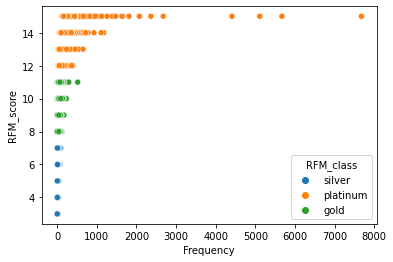

In [31]:
# Frequency와 RFM_score의 살펴보기 위해 산점도를 출력해 봅니다.
# RFM_class를 통해 데이터를 구분할 수 있습니다.
sns.scatterplot(data = rfm, x = "Frequency", y = "RFM_score", hue = "RFM_class")

<AxesSubplot:xlabel='Frequency', ylabel='RFM_score'>

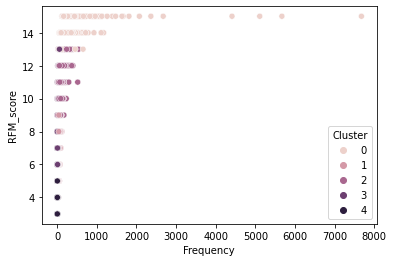

In [32]:
sns.scatterplot(data = rfm, x = "Frequency", y = "RFM_score", hue = "Cluster")

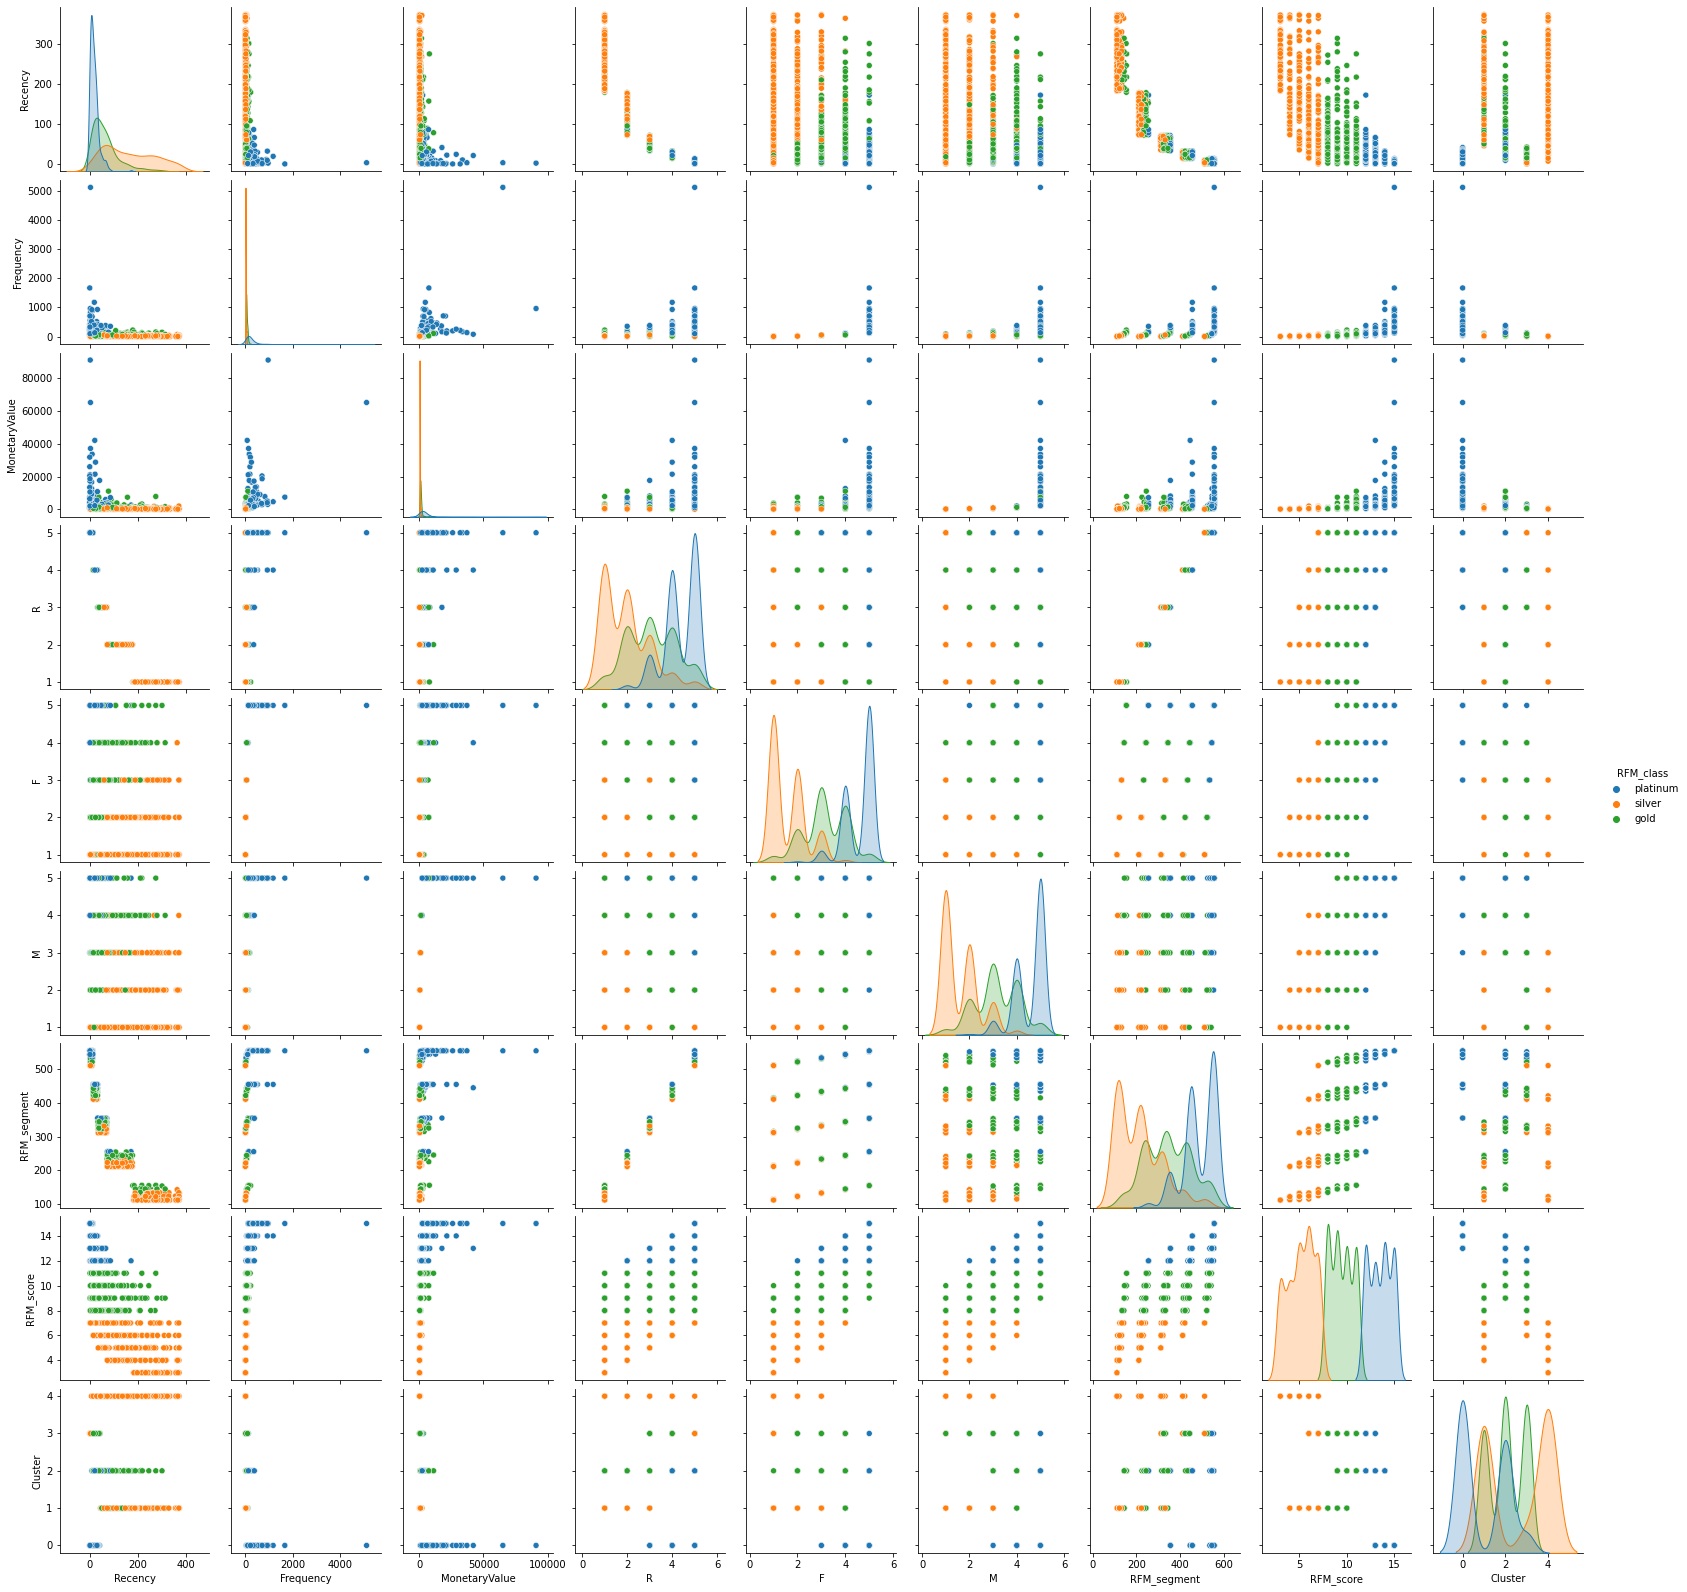

In [33]:
# pairplot을 통해 rfm의 데이터 중 무작위로 1000개의 데이터만을 추출해 pairplot을 시각화 합니다.
# RFM_class를 통해 데이터를 구분할 수 있습니다.
sns.pairplot(data = rfm.sample(1000), hue = "RFM_class")

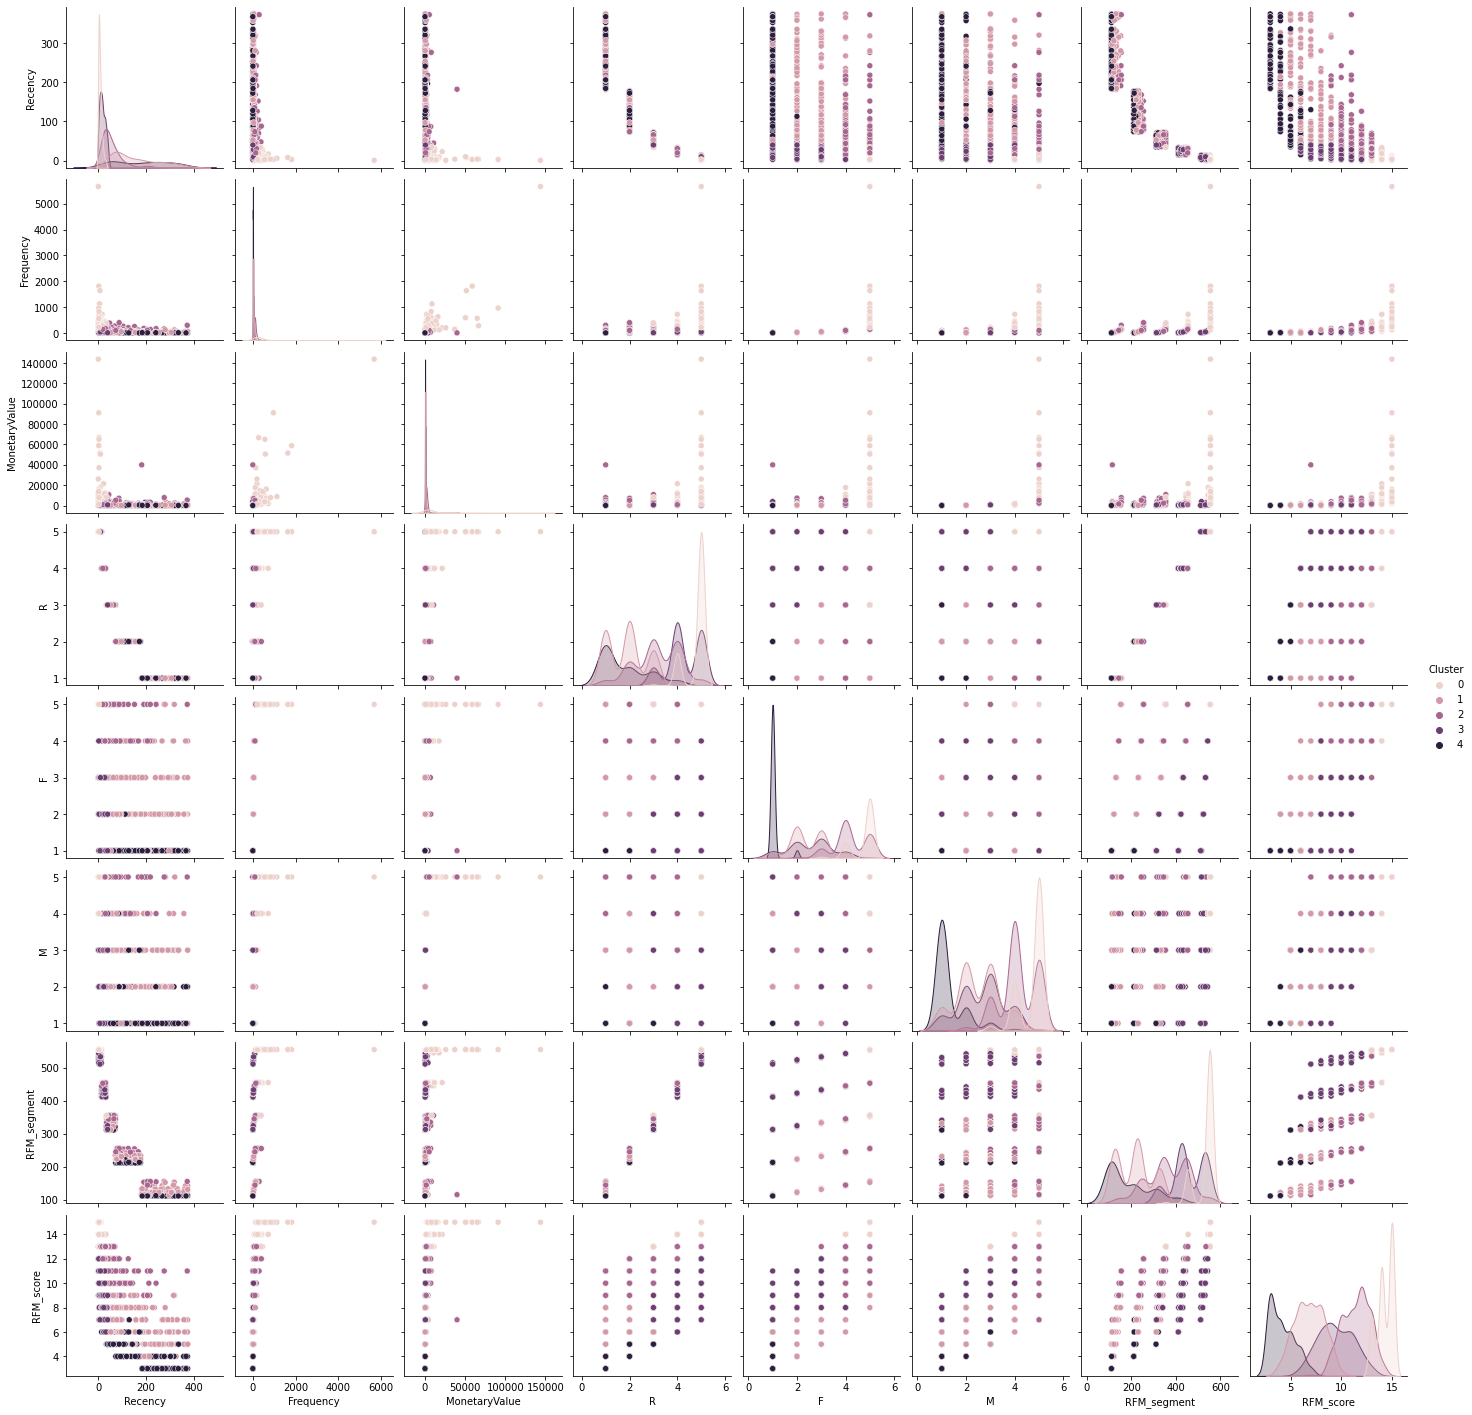

In [34]:
sns.pairplot(data = rfm.sample(1000), hue = "Cluster")